<a href="https://colab.research.google.com/github/Arminhosseini/Crawler_detection/blob/main/Crawler_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml ua-parser user-agents minisom flask

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from user_agents import parse
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from minisom import MiniSom 
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file
from flask import Flask, request
from IPython import get_ipython
from threading import Thread
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Loading data from google drive

In [ ]:
# downloaded = drive.CreateFile({'id':'1NtO5GyJDmK7AV74Jy1_AOx-hZ07YOaah'}) 
downloaded = drive.CreateFile({'id':'13u_cELSwFzpxU2JbFX2QCQRQ4vysxZyR'}) 
downloaded.GetContentFile('dataset.txt')  
data = pd.read_csv("dataset.txt",
                             sep="\t",
                             names=["IP",	"Time",	"Method",	"Path",	"StatusCode",	"ResponseLength",	"UserAgent",	"ResponseTime"])
data.head()

In [ ]:
data.Time = pd.to_datetime(data.Time)

In [ ]:
column_names = ["click_rate", "html_ratio", "error_resp", "HEAD_req", "robot_req", "stdDev_depth", "conseq_req"]
train_data = pd.DataFrame(columns = column_names)

In [ ]:
data.ResponseTime.fillna(data.ResponseTime.mean(), inplace=True)

#Defining session based on similar IP and user agent within every 5 minutes 

##Extract click rate feature for every session

In [ ]:
train_data['click_rate'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')]).apply(lambda x: x.shape[0]).reset_index(name='click_rate')['click_rate']

##Extract HTML ratio, which represents HTML requested pages division by other types of content including pictures, etc.

In [ ]:
train_data['html_ratio'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: (x.Path.str.count('html').sum() / (x.Path.str.count('jpg').sum() + x.Path.str.count('png').sum()))\
       if (x.Path.str.count('jpg').sum() + x.Path.str.count('png').sum()) != 0 else x.Path.str.count('html').sum())\
.reset_index(name='html_ratio')['html_ratio']

##Extract ratio of failed requests

In [ ]:
def errorCount(df):
        try:
            return df.StatusCode.floordiv(100).value_counts(normalize=True)[4]
        except:
            return 0

In [ ]:
train_data['error_resp'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: errorCount(x) )\
.reset_index(name='error_resp')['error_resp']

##Extract ratio of Head requests

In [ ]:
def headerCount(df):
        try:
            return df.Method.value_counts(normalize=True)['Head']
        except:
            return 0

In [ ]:
train_data['HEAD_req'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: headerCount(x) )\
.reset_index(name='HEAD_req')['HEAD_req']

##Extract requests which requested robots.txt path

In [ ]:
train_data['robot_req'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: 1 if x.Path.str.count('robots.txt').sum() > 0 else 0 )\
.reset_index(name='robot_req')['robot_req']

##Extract standard deviation of requested path

In [ ]:
train_data['stdDev_depth'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: (x.Path.str.split('/').str.len()-1).std() if x.shape[0] > 1 else 0)\
.reset_index(name='stdDev_depth')['stdDev_depth']

##Extract if request has sequential path during the session

In [ ]:
train_data['conseq_req'] = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: np.count_nonzero(np.where(x.Path.str.split('/', expand=True)[0] == x.Path.str.split('/', expand=True)[1], True, False) == True) )\
.reset_index(name='conseq_req')['conseq_req']

##Tag some of the data based on prior knowledge

In [ ]:
def agentSplit(x):
  agent = x['UserAgent'].iloc[0]
  parse_agent = parse(agent)
  if agent == 'python-requests/2.18.1' or agent == 'Python-urllib/3.7':
    return 'Crawler'
  elif 'BlackBerry' in agent:
    return 'Attacker'
  elif (x.Path.str.count('robots.txt').sum() > 0) or x.shape[0] > 50:
    return 'malicious'
  elif (parse_agent.is_mobile or parse_agent.is_tablet or parse_agent.is_pc) and (x.Path.str.count('robots.txt').sum() == 0):
    return 'Human'
  elif 'google' in agent or agent == 'Go-http-client' or 'Google' in agent:
    return 'Well-behaved'
  else:
    return 'unknown'

In [ ]:
agent_spec = data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
.apply(lambda x: agentSplit(x))\
.reset_index(name='agent_spec')['agent_spec']

#Normalize data and implementing SOM model

In [ ]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data)

In [ ]:
som = MiniSom(6, 6, train_data.shape[1], sigma=1.5, learning_rate=0.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

In [ ]:
som.train_random(scaled_data, 10000)

#Plotting results

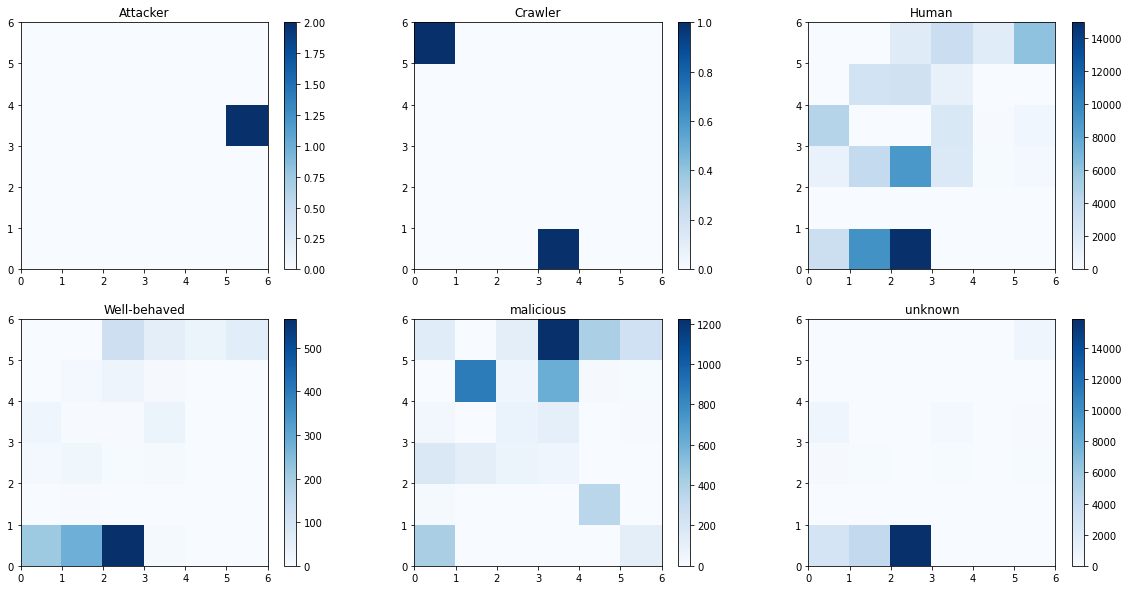

In [ ]:
f = plt.figure(figsize=(20, 10))

ax = f.add_subplot(231)
ax.set_aspect('equal')
ax.set_title("Attacker")
frequencies = som.activation_response(scaled_data[agent_spec=='Attacker'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

ax = f.add_subplot(232)
ax.set_aspect('equal')
ax.set_title("Crawler")
frequencies = som.activation_response(scaled_data[agent_spec=='Crawler'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

ax = f.add_subplot(233)
ax.set_aspect('equal')
ax.set_title("Human")
frequencies = som.activation_response(scaled_data[agent_spec=='Human'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

ax = f.add_subplot(234)
ax.set_aspect('equal')
ax.set_title("Well-behaved")
frequencies = som.activation_response(scaled_data[agent_spec=='Well-behaved'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

ax = f.add_subplot(235)
ax.set_aspect('equal')
ax.set_title("malicious")
frequencies = som.activation_response(scaled_data[agent_spec=='malicious'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

ax = f.add_subplot(236)
ax.set_aspect('equal')
ax.set_title("unknown")
frequencies = som.activation_response(scaled_data[agent_spec=='unknown'])
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()

plt.show()

#Create REST Api for real time input requests evaluation

In [ ]:
get_ipython().system_raw('python3 app.py &')
get_ipython().system_raw('./ngrok http 5000 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://63ad00552850.ngrok.io


In [ ]:
def make_session():
  api_data = pd.DataFrame(columns = column_names)
  global queue_data
  # print("in make session: ", queue_data)
  IP = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')]).apply(lambda x: x['IP'].iloc[0]).reset_index(name='session_ip')['session_ip']

  api_data['click_rate'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')]).apply(lambda x: x.shape[0]).reset_index(name='click_rate')['click_rate']

  api_data['html_ratio'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: (x.Path.str.count('html').sum() / (x.Path.str.count('jpg').sum() + x.Path.str.count('png').sum()))\
  if (x.Path.str.count('jpg').sum() + x.Path.str.count('png').sum()) != 0 else x.Path.str.count('html').sum())\
  .reset_index(name='html_ratio')['html_ratio']

  api_data['error_resp'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: errorCount(x) )\
  .reset_index(name='error_resp')['error_resp']

  api_data['HEAD_req'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: headerCount(x) )\
  .reset_index(name='HEAD_req')['HEAD_req']

  api_data['robot_req'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: 1 if x.Path.str.count('robots.txt').sum() > 0 else 0 )\
  .reset_index(name='robot_req')['robot_req']

  api_data['stdDev_depth'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: (x.Path.str.split('/').str.len()-1).std() if x.shape[0] > 1 else 0)\
  .reset_index(name='stdDev_depth')['stdDev_depth']

  api_data['conseq_req'] = queue_data.groupby(["IP","UserAgent",pd.Grouper(key='Time', freq='5min')])\
  .apply(lambda x: np.count_nonzero(np.where(x.Path.str.split('/', expand=True)[0] == x.Path.str.split('/', expand=True)[1], True, False) == True) )\
  .reset_index(name='conseq_req')['conseq_req']

  # print(api_data)
  return api_data, IP

In [ ]:
def find_malicious():
  sessions, session_ip = make_session()
  x_scaled = scaler.fit_transform(sessions)
  for cnt, x in enumerate(x_scaled):
    w = som.winner(x)
    print("winnner cell: ", w)
    if w == (2, 5):
      print(session_ip[cnt], ": attacker")
    elif w == (0, 0) or w == (5, 3):
      print(session_ip[cnt], ": crawler")
    elif w == (0, 3) or w == (1, 3) or w == (1, 1):
      print(session_ip[cnt], ": malicious") 
    elif w != (2, 5) or w != (1, 5) or w != (0, 5) or w != (2, 3):
      print(session_ip[cnt], ": maybe malicious")

   

In [ ]:
app = Flask(__name__)
queue_data = pd.DataFrame({})

@app.route('/senddata', methods=['POST'])
def index():
    global queue_data
    str_x = request.get_data().decode()
    splited_x = str_x.split('[')
    IP = splited_x[0].split(" ")[0].split("'")[1]
    Time = pd.to_datetime(splited_x[1].split("]")[0])
    Method = splited_x[2].split(" ")[0]
    Path = splited_x[2].split(" ")[1].split("]")[0]
    StatusCode = splited_x[2].split(" ")[2]
    ResponseLength = splited_x[2].split(" ")[3]
    UserAgent = splited_x[4].split(" ")[0].split("]")[0]
    ResponseTime = splited_x[4].split(" ")[1].split("'")[0]
    df = pd.DataFrame({"IP":[IP],"Time":[Time], "Method":[Method], "Path":[Path],
                       "StatusCode":[StatusCode], "ResponseLength":[ResponseLength], "UserAgent":[UserAgent],
                       "ResponseTime":[ResponseTime]})
    queue_data = queue_data.append(df)
    # print("in flask route: ", queue_data)
    thread = Thread(target=find_malicious)
    thread.daemon = True
    thread.start()
    return "success"

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
